In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage[mtpbb, mtpcal]{mtpro2}"]

In [2]:
def normalize(X, axis = 0, mean = True, std = True):
        '''
        Conduct mean-standard deviation normalization.

        Parameters
        ----------
        X : array-like, shape = [n_1, n_2, ..., n_{`X.ndim`-1}]
            Data matrix

        axis : int, 0 to `X.ndim` - 1
            The axis needs to be normalized

        mean : bool,
            Whether to normalize the mean to zero

        std : bool
            Whether to normalize the variance to one

        Returns
        -------
        X_normalized : array, shape = [num_observations, num_features]
            The design matrix after normalizing
        '''
        standard_deviation = X.std(axis = axis)
        valid_std = (np.abs(standard_deviation).all() >= 1e-16)
        if std == True and (valid_std == False):
            raise ZeroDivisionError, "Zero standard deviation encountered."
        X_normalized = (X - X.mean(axis = axis) * mean) / standard_deviation
        return X_normalized

In [3]:
class LinearRegression():
    
    def __init__(self, regularizer = {"reg_type": "L2", "reg_strength": 0.0}, optimizer = "GD"):
        self.regularizer = regularizer
        self.optimizer = optimizer
        self.counter = 0
        assert self.regularizer["reg_type"] in ["L1", "L2"], "`reg_type` must be `L1` or `L2`"
        assert self.regularizer["reg_strength"] >= 0 or self.regularizer["reg_strength"] == None, \
               "`reg_strength` must be non-negative"
        assert self.optimizer in ["GD", "SGD", "Proximal"], "`optimizer` must be `GD`, `SGD` or `Proximal`"
        if self.regularizer["reg_type"] != "L1" and self.optimizer == "Proximal":
            raise NameError, "In this class, proximal gradient descent only for L1 regularizer"
        if self.regularizer["reg_type"] == "L1" and self.optimizer != "Proximal":
            raise NameError, "Use proximal gradient descent for lasso"
        
    def training(self, X, y, step_size = 0.01, decay = 1, tolerance = 0.01):
        self.X = self._add_intercept(X)
        self.y = y
        self.weights = np.zeros(self.X.shape[-1])
        self.step_size = step_size    
        self.tolerance = tolerance
        self.index = np.arange(len(self.X))
        self.decay = decay
        self.weights_previous = np.repeat(np.inf,self.X.shape[-1])
        self.loss_collection = []
        assert self.tolerance > 0, "`tolerance` should be positive"
        assert 0 < self.decay <= 1, "`decay` should be in (0, 1]"

        
        while np.linalg.norm(self.weights - self.weights_previous) > tolerance:
            self.counter = self.counter + 1
            self.weights_previous = self.weights.copy()
            self._optimizer()
            self.step_size = self.decay * self.step_size
        print "After {} iterations converges.".format(self.counter)    
        
    def _optimizer(self):
        temp = self.weights.copy()
        temp[0] = 0.0
        if self.optimizer == "GD":
            self.weights = self.weights - self.step_size * (2.0 / self.X.shape[0] * np.dot(self.X.T,
                           np.dot(self.X, self.weights) - self.y) + 2 * self.regularizer["reg_strength"] * temp)
            self.loss_collection.append(np.linalg.norm(np.dot(self.X, self.weights) - self.y) / self.X.shape[0] + \
                                        self.regularizer["reg_strength"] * np.linalg.norm(self.weights) ** 2)    
        elif self.optimizer == "SGD":
            t = np.random.choice(self.index, replace = True)
            self.weights = self.weights - self.step_size * 2.0 * ((np.dot(self.X[t], self.weights) - self.y[t])\
                                                                            * self.X[t] + self.regularizer["reg_strength"] * temp)
            self.loss_collection.append(np.linalg.norm(np.dot(self.X, self.weights) - self.y) ** 2 / self.X.shape[0] + \
                                        self.regularizer["reg_strength"] * np.linalg.norm(self.weights) ** 2) 
        else:
            self.weights = self.weights - 2.0 / self.X.shape[0] * self.step_size * np.dot(self.X.T, 
                           np.dot(self.X, self.weights) - self.y)
            self.weights = self._soft_thresholding(self.weights, self.regularizer["reg_strength"])
            self.loss_collection.append(np.linalg.norm(np.dot(self.X, self.weights) - self.y) ** 2 / self.X.shape[0] + \
                                        self.regularizer["reg_strength"] * np.linalg.norm(self.weights, ord = 1))
            
    def _add_intercept(self, X):
            return np.hstack(((np.ones(X.shape[0])).reshape((-1, 1)), X))
    
    def _soft_thresholding(self, x, threshold):
        return np.sign(x) * np.maximum(0, np.abs(x) - threshold)
    
    def predicting(self, X):
        return np.dot(X, self.weights)
    
    def plot_trace(self, X, y, step_size = 0.01, decay = 1, tolerance = 0.01, reg_coef = [0, 1, 10, 20, 30, 50, 100, 200]):
        weights_collection = []
        for i in range(len(reg_coef)):
            self.regularizer["reg_strength"] = reg_coef[i]
            self.training(X, y, step_size, decay, tolerance)
            weights_collection.append(self.weights)
        result = weights_collection[0]
        for i in range(len(weights_collection)-1):
            result = np.vstack((result, weights_collection[i+1]))
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot(111)
        for i in range(1, self.X.shape[-1]):
            ax.plot(np.array(reg_coef), result[:, i], '-', label = '{}-th Feature'.format(i))
        ax.legend()
        
    def get_loss(self, X, y):
        return np.linalg.norm(np.dot(self.X, self.weights) - self.y) ** 2 / self.X.shape[0] + \
                                        self.regularizer["reg_strength"] * np.linalg.norm(self.weights, ord = 1)
    def plot_loss(self):
        plt.plot(self.loss_collection)

    

In [4]:
X, y, coef = datasets.make_regression(n_samples=1007, n_features=6, n_informative = 3, bias=1, coef = True, noise=5, 
                                      tail_strength=0.0)
X = normalize(X)
y = normalize(y)

After 8 iterations converges.


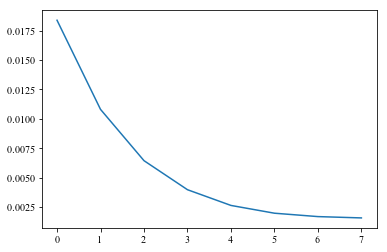

In [5]:
reg_strength = 0
stepsize_for_GD = 1.0 / (2.0 / X.shape[0] * np.linalg.norm(X, axis = 1).sum() + 2 * reg_strength)
stepsize_for_SGD = 10 ** -6
stepsize_for_Proximal = stepsize_for_GD
predictor = LinearRegression(regularizer={"reg_type": "L2", "reg_strength": reg_strength}, optimizer = "GD")
predictor.training(X, y, step_size = stepsize_for_GD, decay=1, tolerance = 0.01)
predictor.plot_loss()

After 7 iterations converges.


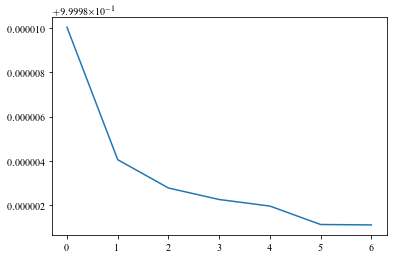

In [6]:
predictor = LinearRegression(regularizer={"reg_type": "L2", "reg_strength": reg_strength}, optimizer = "SGD")
predictor.training(X, y, step_size = stepsize_for_SGD, decay=0.7, tolerance = 10**-7)
predictor.plot_loss()

After 12 iterations converges.


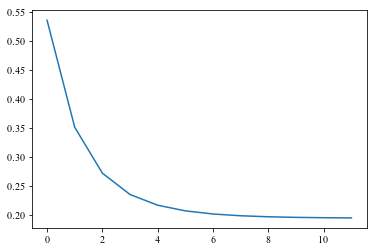

In [7]:
reg_strength = 0.1
predictor = LinearRegression(regularizer={"reg_type": "L1", "reg_strength": reg_strength}, optimizer = "Proximal")
predictor.training(X, y, step_size = stepsize_for_Proximal, decay=1, tolerance = 10**-3)
predictor.plot_loss()

After 36 iterations converges.
After 68 iterations converges.
After 96 iterations converges.
After 121 iterations converges.
After 142 iterations converges.
After 158 iterations converges.
After 170 iterations converges.
After 178 iterations converges.
After 180 iterations converges.
After 181 iterations converges.


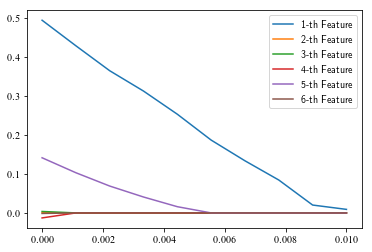

In [8]:
predictor = LinearRegression(regularizer={"reg_type": "L1", "reg_strength": reg_strength}, optimizer = "Proximal")
predictor.plot_trace(X, y, step_size = 0.01, reg_coef = np.linspace(0,0.01,10))